In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [3]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

# import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
# from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
# from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
# import xitorch
# from xitorch.linalg import symeig

from glob import glob

from scipy.linalg import eigvalsh
from pathlib import Path
# from mlelec.utils.pbc_utils import  TMap_bloch_sums_feat
plt.rcParams['figure.figsize'] = 2*1.618, 2
plt.rcParams['figure.dpi'] = 300

In [36]:
from mlelec.utils.metatensor_utils import sort_block_hack, sort_hack
from mlelec.utils.pbc_utils import move_orbitals_to_keys

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
root = '/scratch/pegolo/seed_73'
workdir = f'{root}/test_integrated_model'
resdir = f'{workdir}/results'
device = 'cpu'
cutoff = 8
overwrite = True

Path(resdir).mkdir(exist_ok = overwrite)
orbitals = {6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}
orbital_names = 'sto-3g'


kmesh = [8,8,1]

# Load checkpoints

In [166]:
checkpoints = {}

start = 0

for space in ['real_space', 'kspace']:
    checkpoints[space] = {}
    strategies = [s.split('/')[-1] for s in glob(f'{workdir}/{space}/*')]
    
    for strategy in strategies:
        checkpoints[space][strategy] = {}
        stops = sorted([int(s.split('/')[-1].split('_')[-1]) for s in glob(f'{workdir}/{space}/{strategy}/train_{start}_*')])
        
        for stop in stops:
            folder = f'{workdir}/{space}/{strategy}/train_{start}_{stop}'
            try:
                nbest = max([int(f.split('/')[-1].split('.')[0].split('_')[1]) for f in glob(f'{folder}/model*ckpt')])
                print(space, strategy, stop, nbest)
                checkpoints[space][strategy][stop] = torch.load(f'{folder}/model_{nbest}.ckpt')
            except:
                print(f'No useful data in {folder}')

real_space a 20 440
real_space a 60 660
real_space a 100 820
real_space a_usual 20 260
real_space a_usual 60 240
real_space a_usual 100 360
kspace d 20 440
kspace d 60 620
kspace d 100 580
kspace d_usual 20 440
kspace d_usual 60 600
kspace d_usual 100 640


# Test dataset

In [32]:
# Define dataset
START, STOP = 140, 172
indices = np.loadtxt(f'{root}/random_indices.txt', dtype = int)[START:STOP]
frames = [read(f'{root}/test/C2_174.extxyz', index = i) for i in indices]
rfock = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{root}/test/data/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rover = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]

dataset = QMDataset(frames = frames,
                    kmesh = kmesh,
                    dimension = 2,
                    fock_realspace = rfock,
                    overlap_realspace = rover,
                    device = device,
                    orbs = orbitals,
                    orbs_name = orbital_names)

## Test targets

In [34]:
_, test_coupled_blocks = get_targets(dataset, cutoff = 8)
phase, _ ,_= precompute_phase(test_coupled_blocks, dataset)
test_coupled_blocks_k = TMap_bloch_sums(test_coupled_blocks, phase, return_tensormap=True)

In [209]:
ntest = sum([np.prod(b.values.shape) for b in test_coupled_blocks.blocks()])

In [67]:
_, overlap_blocks = get_targets(dataset, cutoff = 8, target = 'overlap')
Sk = dataset.bloch_sum(blocks_to_matrix(overlap_blocks, dataset))

In [35]:
target_keynames = test_coupled_blocks.keys.names
keys = []
blocks= []
for k,b in test_coupled_blocks.items(): 
    li,lj, L = k['l_i'], k['l_j'], k['L']
    inversion_sigma = (-1) ** (li + lj + L)
    keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
    blocks.append(b.copy())
test_coupled_blocks_integrated = TensorMap(Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
test_coupled_blocks_integrated_copy = test_coupled_blocks_integrated.copy()
test_coupled_blocks_integrated = test_coupled_blocks_integrated.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

In [37]:
int_phase, _,_ = precompute_phase(test_coupled_blocks_integrated, dataset)
test_coupled_blocks_integrated_k = TMap_bloch_sums(test_coupled_blocks_integrated, int_phase)

In [100]:
test_Hk = dataset.bloch_sum(blocks_to_matrix(test_coupled_blocks, dataset, detach = True))
ev_ = []
for H, S in zip(test_Hk, Sk):
    ev__ = []
    for ik in range(len(H)):
        ev__.append(eigvalsh(H[ik].detach().numpy(), S[ik]))
    ev_.append(ev__)
test_eigenvalues = np.array(ev_)

## Test features

In [40]:
test_features = mts.load(f'{root}/test/features_140_172_seed73')

# Models performance

In [167]:
from mlelec.models.linear import LinearModelPeriodic
nhidden = 9
model_usual = LinearModelPeriodic(twocfeat = test_features,
                            target_blocks = test_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = nhidden, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

print(f'Usual model with {count_parameters(model_usual)} parameters.')

from mlelec.models.linear_integrated import LinearModelPeriodic
nhidden = 16
model_integrated = LinearModelPeriodic(twocfeat = test_features,
                                        target_blocks = test_coupled_blocks_integrated,
                                        frames = dataset.structures, orbitals = dataset.basis, 
                                        device = device,
                                        bias = True,
                                        nhidden = nhidden, 
                                        nlayers = 1,
                                        activation = 'SiLU',
                                        apply_norm = True
                                       )

print(f'Integrated model with {count_parameters(model_integrated)} parameters.')

Usual model with 74628 parameters.
Integrated model with 71577 parameters.


In [211]:
eigenvalues = {}
predicted_Hk = {}
learning_curve = {}

for space in checkpoints:
    eigenvalues[space] = {}
    predicted_Hk[space] = {}
    learning_curve[space] = {}

    for strategy in checkpoints[space]:
        eigenvalues[space][strategy] = {}
        predicted_Hk[space][strategy] = {}
        learning_curve[space][strategy] = {}
        
        if strategy.split('_')[-1] == 'usual':
            model = model_usual
            target = test_coupled_blocks
            target_k = test_coupled_blocks_k
            ph = phase
        else:
            model = model_integrated
            target = test_coupled_blocks_integrated
            target_k = test_coupled_blocks_integrated_k
            ph = int_phase
        
        print(space, strategy)
            
        for N in checkpoints[space][strategy]:
            
            ckpt = checkpoints[space][strategy][N]
            print(f'   {N}', ckpt['epoch'])
            
            model.load_state_dict(ckpt['model_state_dict'])
            prediction = model.predict(test_features, target)
            prediction_k = TMap_bloch_sums(prediction, ph)

            Hk = dataset.bloch_sum(blocks_to_matrix(prediction, dataset, detach = True))
            ev_ = []
            for H, S in zip(Hk, Sk):
                ev__ = []
                for ik in range(len(H)):
                    ev__.append(eigvalsh(H[ik].detach().numpy(), S[ik]))
                ev_.append(ev__)
            eigenvalues[space][strategy][N] = np.array(ev_) 
            predicted_Hk[space][strategy][N] = Hk

            n = sum([np.prod(b.values.shape) for b in prediction.blocks()])
            if space == 'real_space':
                learning_curve[space][strategy][N] = {'train': np.sqrt(ckpt['loss']/n), 'test': np.sqrt(L2_loss(prediction, target).item()/ntest)}
            else:
                learning_curve[space][strategy][N] = {'train': np.sqrt(ckpt['loss']/n), 'test': np.sqrt(L2_loss(prediction_k, target_k).item()/ntest)}
                
            
            print(f'    Real loss: {L2_loss(prediction, target).item():.5f}')
            print(f'       k loss: {L2_loss(prediction_k, target_k).item()/128:.5f}')
        print('')

real_space a
   20 440
    Real loss: 0.40233
       k loss: 0.39895
   60 660
    Real loss: 0.06559
       k loss: 0.06546
   100 820
    Real loss: 0.00456
       k loss: 0.00451

real_space a_usual
   20 260
    Real loss: 2.57635
       k loss: 2.56369
   60 240
    Real loss: 0.41723
       k loss: 0.41664
   100 360
    Real loss: 0.01116
       k loss: 0.01099

kspace d
   20 440
    Real loss: 0.44425
       k loss: 0.44277
   60 620
    Real loss: 0.06144
       k loss: 0.06127
   100 580
    Real loss: 0.00454
       k loss: 0.00443

kspace d_usual
   20 440
    Real loss: 1.17714
       k loss: 1.17605
   60 600
    Real loss: 0.15097
       k loss: 0.15079
   100 640
    Real loss: 0.00404
       k loss: 0.00391



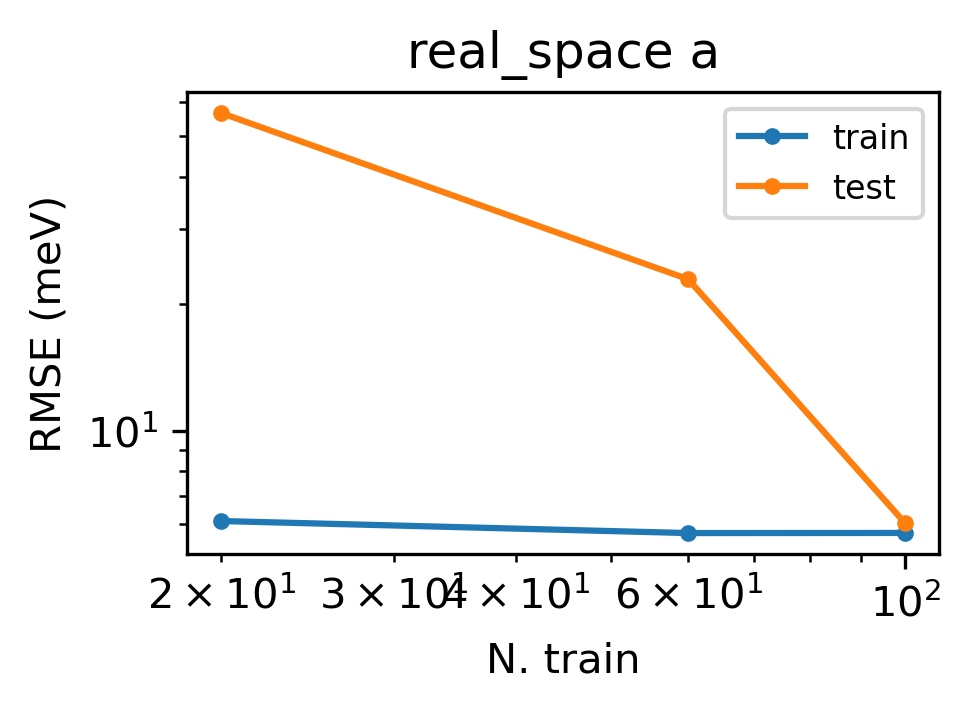

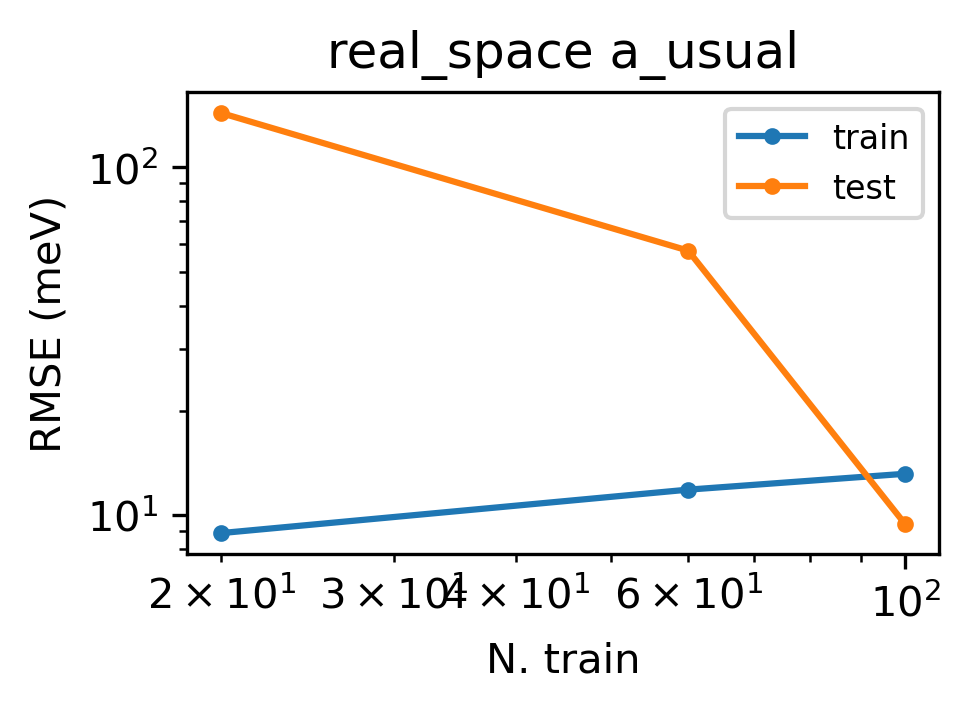

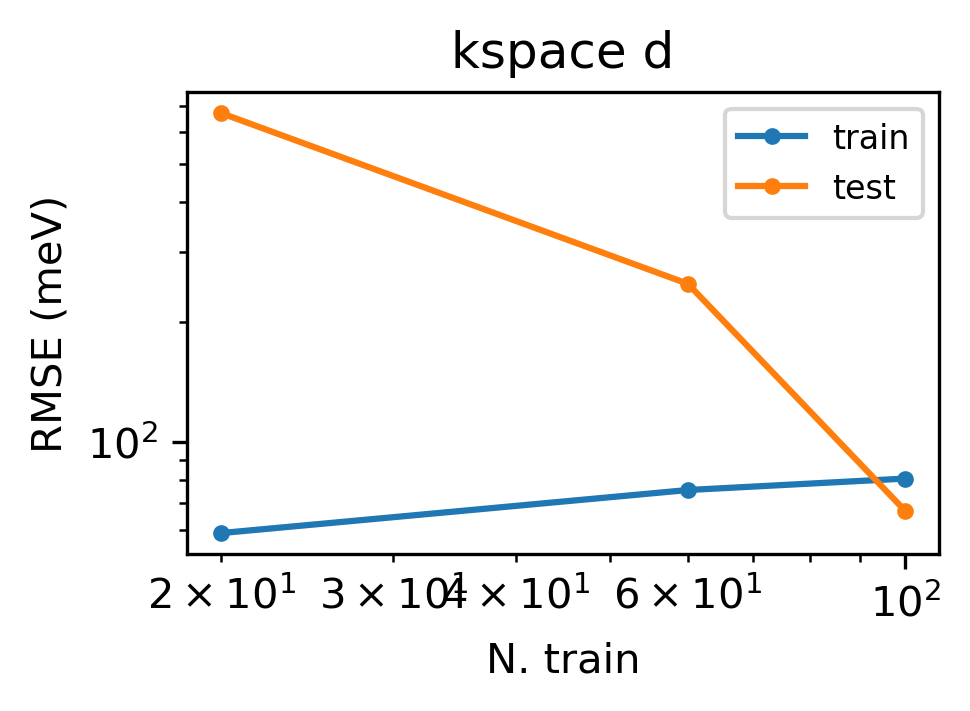

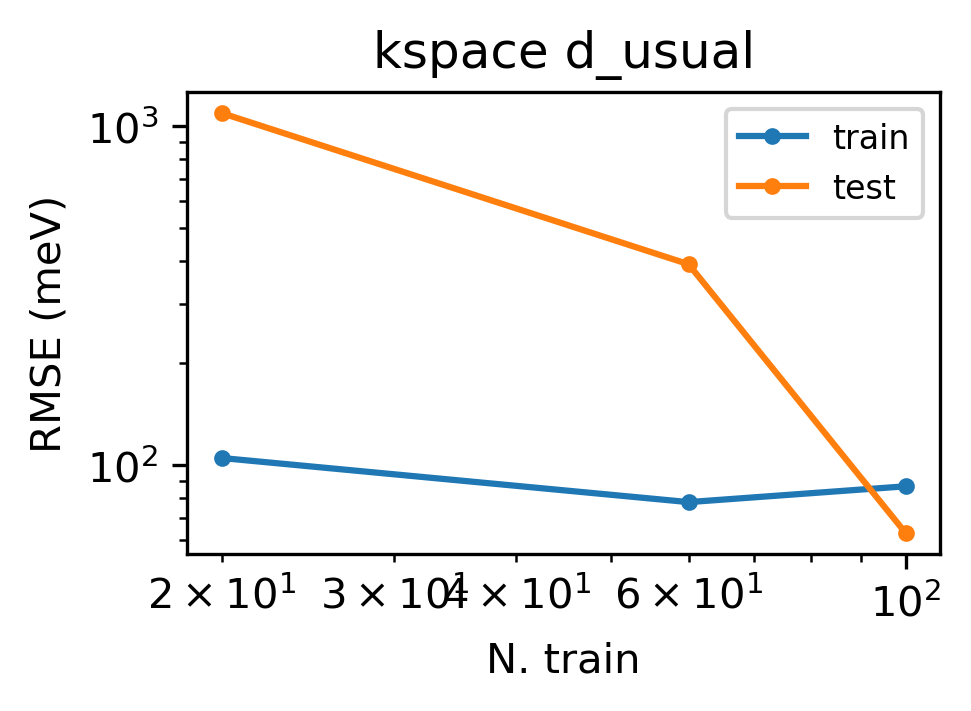

In [213]:
from ase.units import Hartree

for space in eigenvalues:
    
    for strategy in eigenvalues[space]:
        fig, ax = plt.subplots()

        x = np.array([N for N in learning_curve[space][strategy]])
        for dset in ['train', 'test']:
            y = np.array([learning_curve[space][strategy][N][dset] for N in learning_curve[space][strategy]])*Hartree*1000
            ax.loglog(x, y, '-o', markersize = 3, alpha = 1, label = dset)
            
        ax.set_title(f'{space} {strategy}')
        ax.legend(fontsize = 8)
        ax.set_xlabel('N. train')
        ax.set_ylabel('RMSE (meV)')

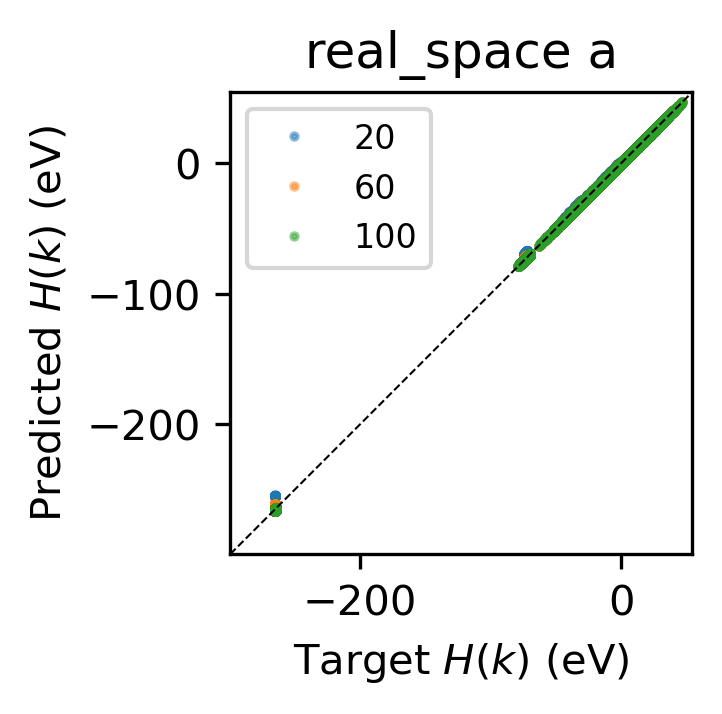

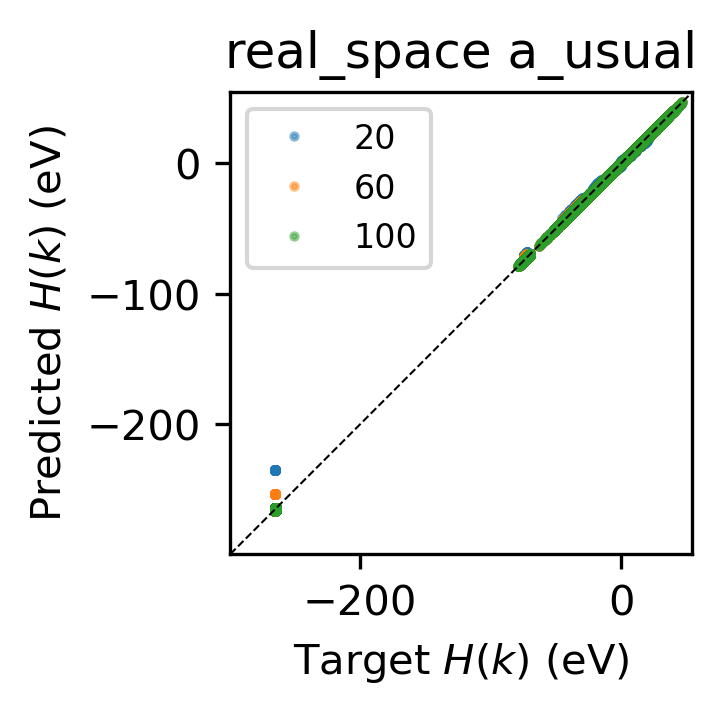

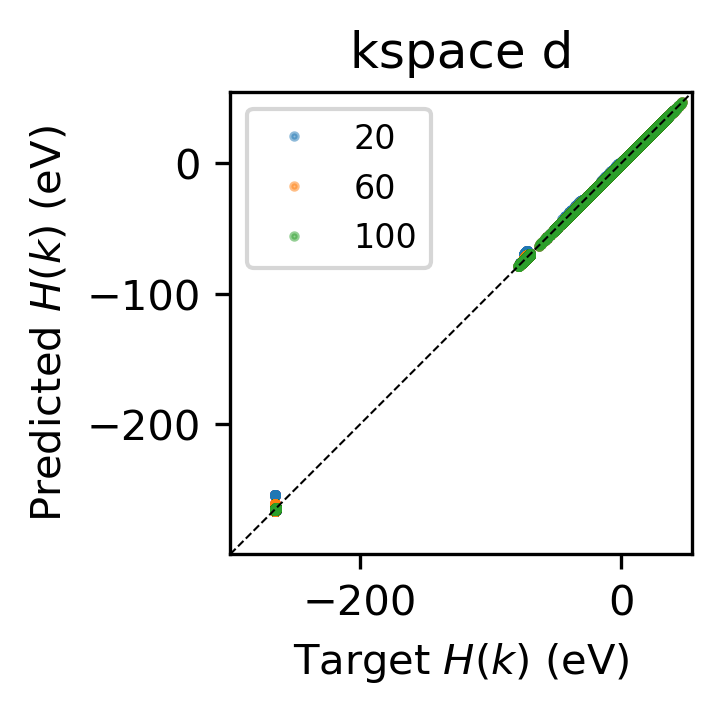

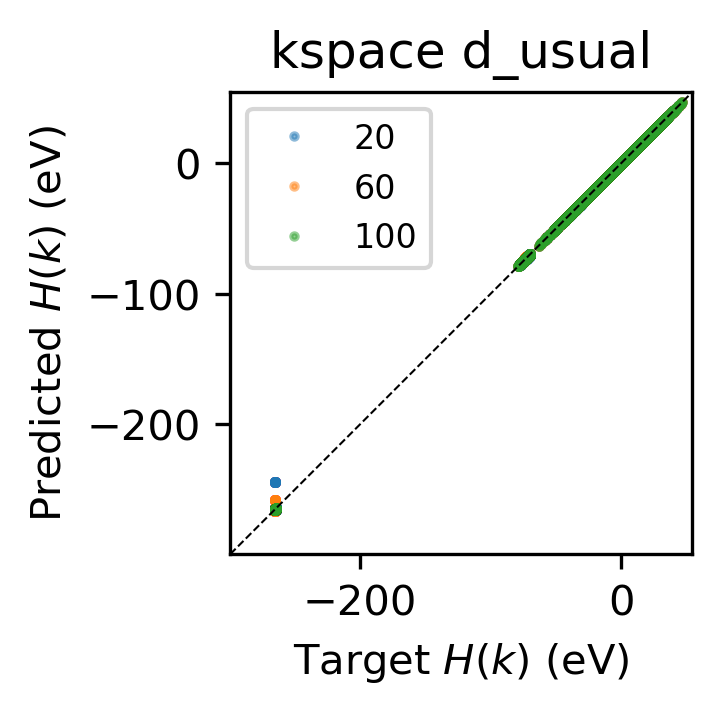

In [169]:
from ase.units import Hartree

x = torch.stack(test_Hk).flatten() * Hartree

for space in eigenvalues:
    
    for strategy in eigenvalues[space]:
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        for N in eigenvalues[space][strategy]:
            y = torch.stack(predicted_Hk[space][strategy][N]).flatten() * Hartree
            # for x, y in zip(test_eigenvalues, eigenvalues[space][strategy][N]): 
            ax.plot(x.real, y.real, '.', markersize = 3, label = N, alpha = 0.5)

        ax.set_title(f'{space} {strategy}')
        ax.legend(fontsize = 8)
        xmin = -11*Hartree
        xmax = 2*Hartree
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(xmin, xmax)
        ax.plot([xmin, xmax], [xmin, xmax], '--k', lw = 0.5)
        ax.set_xlabel('Target $H(k)$ (eV)')
        ax.set_ylabel('Predicted $H(k)$ (eV)')

        # fig.savefig(f'{resdir}/parity_hamiltonian_{space}_{strategy}.png', dpi = 300, bbox_inches = 'tight')

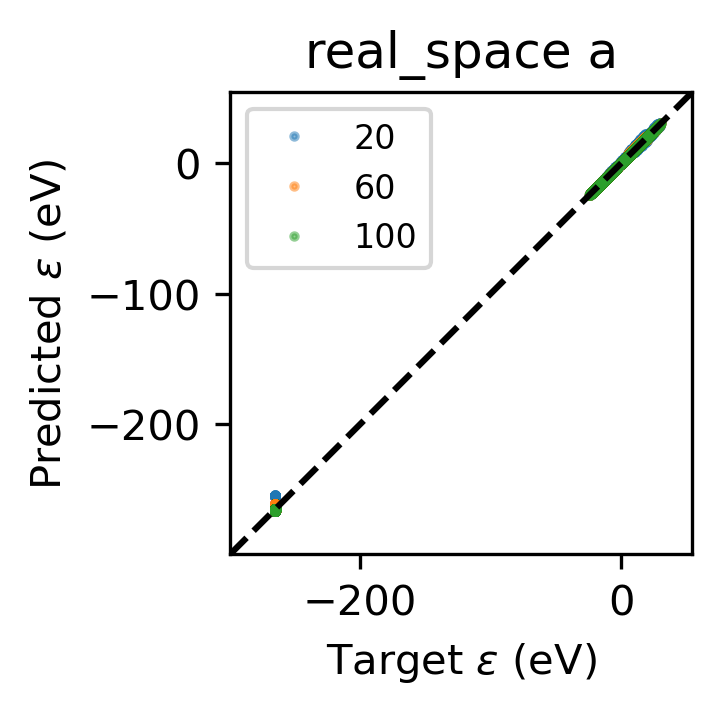

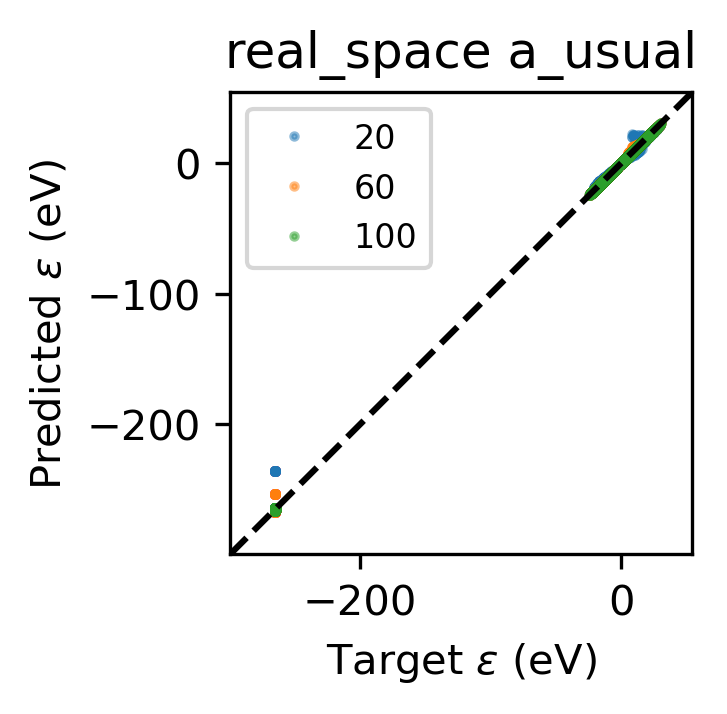

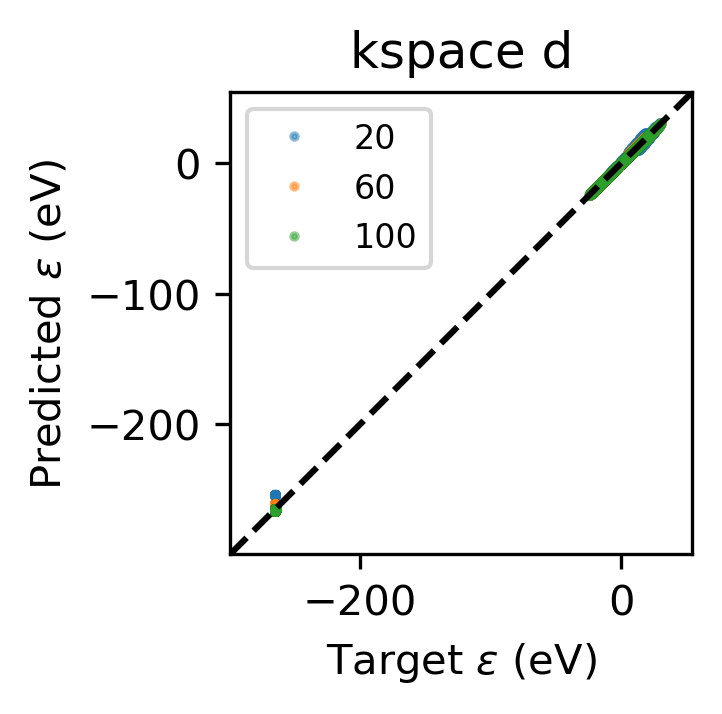

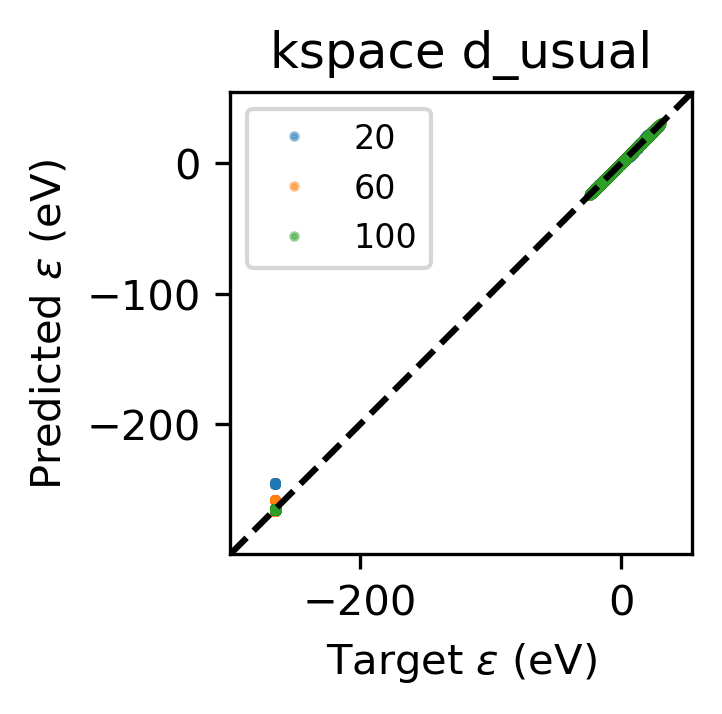

In [170]:
from ase.units import Hartree

x = test_eigenvalues.flatten() * Hartree

for space in eigenvalues:
    
    for strategy in eigenvalues[space]:
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        for N in eigenvalues[space][strategy]:
            y = eigenvalues[space][strategy][N].flatten() * Hartree
            # for x, y in zip(test_eigenvalues, eigenvalues[space][strategy][N]): 
            ax.plot(x, y, '.', markersize = 3, label = N, alpha = 0.5)

        ax.set_title(f'{space} {strategy}')
        ax.legend(fontsize = 8)
        xmin = -11*Hartree
        xmax = 2*Hartree
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(xmin, xmax)
        ax.plot([xmin, xmax], [xmin, xmax], '--k')
        ax.set_xlabel('Target $\epsilon$ (eV)')
        ax.set_ylabel('Predicted $\epsilon$ (eV)')

        fig.savefig(f'{resdir}/parity_eigenvalues_{space}_{strategy}.png', dpi = 300, bbox_inches = 'tight')

# Error propagation on the core eigenvalues

In [148]:
test_HT = blocks_to_matrix(test_coupled_blocks, dataset, detach = True)

In [144]:
h_Gamma = test_Hk[0][0].real
s_Gamma = Sk[0][0].real

In [145]:
eigv = eigvalsh(h_Gamma, s_Gamma)

In [161]:
scale = 4e-3
HT_noise = {}
for T in test_HT[0]:
    noise = torch.randn_like(test_HT[0][T])*scale 
    noise = 0.5*(noise+noise.T)
    HT_noise[T] = test_HT[0][T] + noise
h_Gamma_gaussnoise = dataset.bloch_sum([HT_noise])[0][0]
# h_Gamma_gaussnoise = h_Gamma + torch.randn_like(h_Gamma)*scale
eigv_gaussnoise = eigvalsh(h_Gamma_gaussnoise, s_Gamma)

Text(0, 0.5, 'Predicted $\\epsilon$ (eV)')

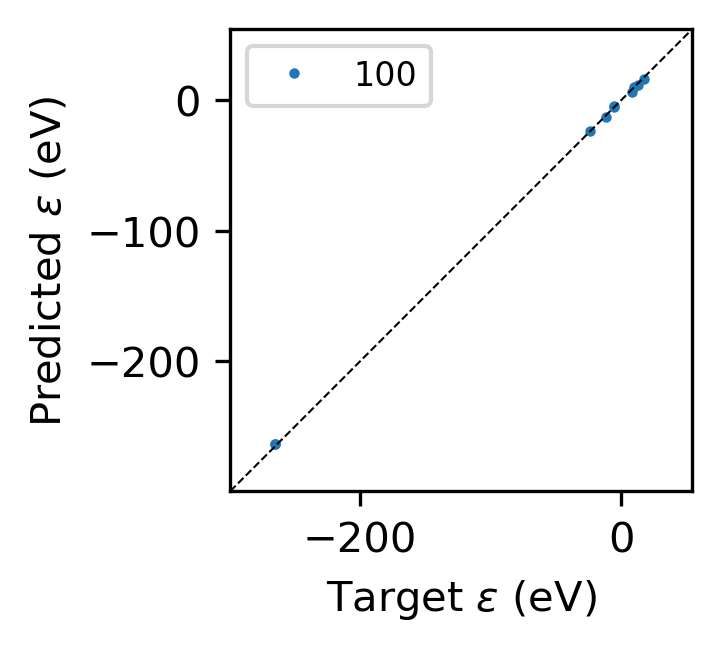

In [162]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
x = eigv * Hartree
y = eigv_gaussnoise * Hartree
ax.plot(x, y, '.', markersize = 3, label = N, alpha = 1)

ax.legend(fontsize = 8)
xmin = -11*Hartree
xmax = 2*Hartree
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.plot([xmin, xmax], [xmin, xmax], '--k', lw = 0.5)
ax.set_xlabel('Target $\epsilon$ (eV)')
ax.set_ylabel('Predicted $\epsilon$ (eV)')

In [165]:
ee=eigvalsh(s_Gamma)
ee[-1]/ee[0]

26.908514033393484

In [54]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = target_coupled_blocks_k,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_k,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0004)


(1e-10, 0.0005232541480597252)

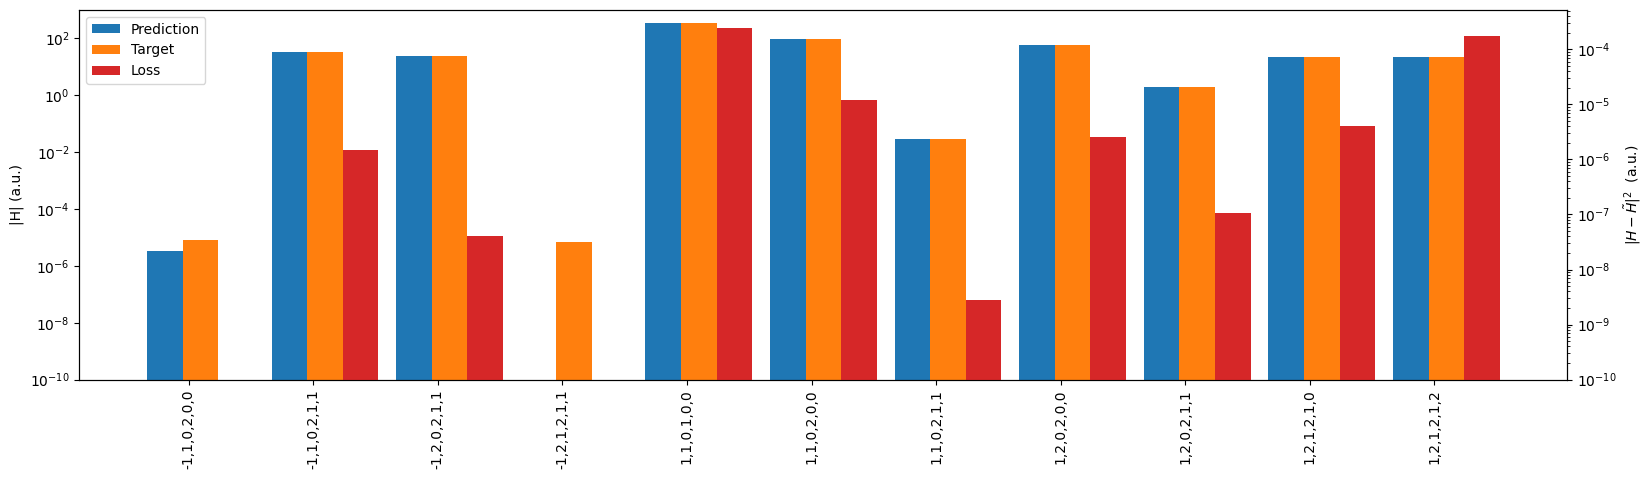

In [22]:
fig, ax, ax2 = plot_block_errors(target_coupled_blocks_k, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-10,)
ax2.set_ylim(1e-10,)

In [92]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = kblocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         kblocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0004)


### E. - baselined H(k)

In [22]:
phase, indices ,_= precompute_phase(target_coupled_blocks_base, dataset)
target_coupled_blocks_base_k = TMap_bloch_sums(target_coupled_blocks_base, phase, indices, _, return_tensormap=True)

In [23]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = target_coupled_blocks_base_k,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_base_k,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(7.4700e-07)


### G. - orthogonalize H(k) 

In [105]:
ortho_target_kspace =[]# torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(ttarget_kspace, overlap_kspace)])
for ifr in range(len(target_kspace)):
    ot = torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(target_kspace[ifr], overlap_kspace[ifr])])
    ortho_target_kspace.append(ot)

In [106]:
e_ortho=[]
for ifr in range(len(ortho_target_kspace)):
   eifr=[]
   for k in range(len(ortho_target_kspace[ifr])):
      eifr.append(torch.linalg.eigvalsh(ortho_target_kspace[ifr][k]))
   e_ortho.append(torch.stack(eifr))

In [107]:
import scipy
e_nonorth=[]
for ifr in range(len(target_kspace)):
   eifr=[]
   for k in range(len(target_kspace[ifr])):
      eifr.append(torch.tensor(scipy.linalg.eigvalsh(target_kspace[ifr][k], overlap_kspace[ifr][k])))
   e_nonorth.append(torch.stack(eifr))

In [108]:
for ifr in range(len(dataset)):
    print(ifr, torch.norm(e_ortho[ifr]-e_nonorth[ifr]))

0 tensor(1.3181e-13)
1 tensor(1.3615e-13)
2 tensor(1.4274e-13)
3 tensor(1.1559e-13)
4 tensor(1.1993e-13)


In [62]:
# plt.plot(torch.cat(e_ortho).numpy(), torch.cat(e_nonorth).numpy(), 'o')

In [109]:
oblocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff, matrix = ortho_target_kspace),skip_symmetry = False, device = device, translations = False)
oblocks = sort_hack(oblocks)

In [114]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = oblocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         oblocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-20,4, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(10058.2337)


(1e-10, 5432.72529376023)

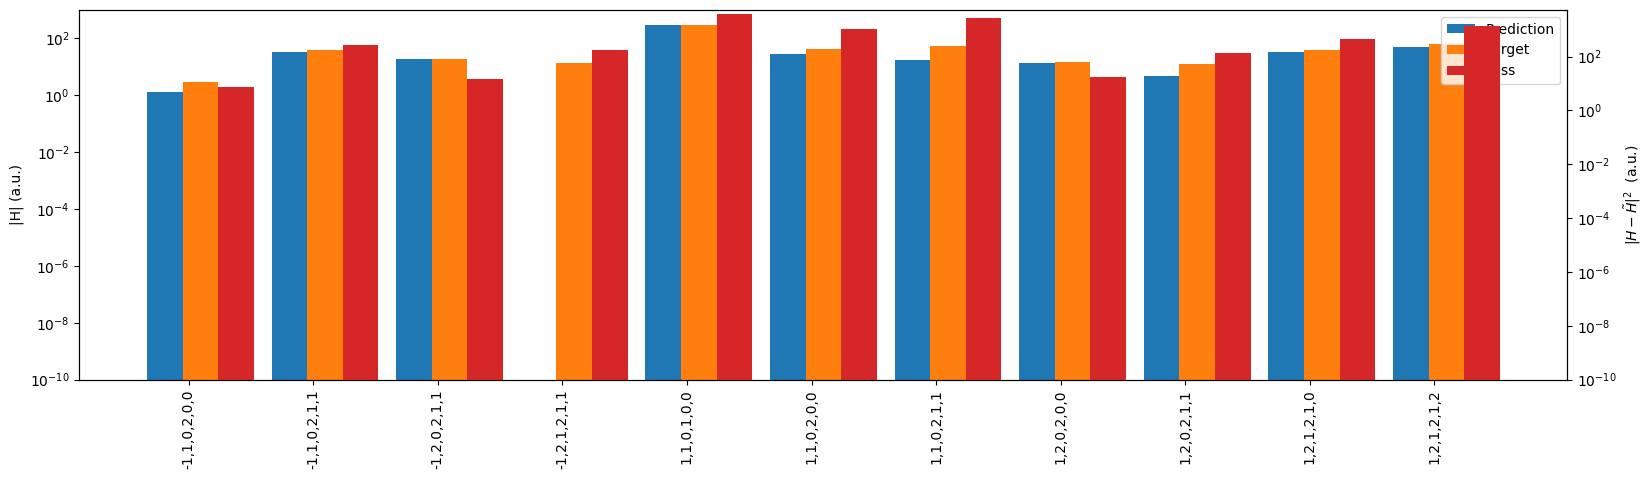

In [115]:
fig, ax, ax2 = plot_block_errors(oblocks, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-10,)
ax2.set_ylim(1e-10,)

### H. - orthogonalize baseline

In [100]:
ortho_target_kspace_base =[]# torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(ttarget_kspace, overlap_kspace)])
for ifr in range(len(target_kspace)):
    ot = torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(target_kspace_base[ifr], overlap_kspace[ifr])])
    ortho_target_kspace_base.append(ot)

In [101]:
oblocks_base = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff, matrix = ortho_target_kspace_base),skip_symmetry = False, device = device, translations = False)
oblocks_base = sort_hack(oblocks_base)

In [104]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = oblocks_base,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         oblocks_base,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7,2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.6547)
